In [2]:
%load_ext jupyter_black
import torch
import torch.optim as optim
import torch.nn as nn
from lsgd import LSGD
import matplotlib.pyplot as plt
import numpy as np
import scienceplots

plt.style.use(["grid", "science", "no-latex"])

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Sanity check with a toy problem

In [3]:
r"""The following code is a toy classification problem from the pytorch documentation.
    https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
"""

import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root="./CIFAR", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./CIFAR", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


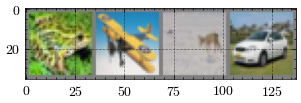

frog  plane deer  car  


In [4]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_sgd = Net()
net_lsgd = Net()

In [6]:
criterion = nn.CrossEntropyLoss()
sgd = optim.SGD(net_sgd.parameters(), lr=0.001, momentum=0.9)
lsgd = LSGD(net_lsgd.parameters(), lr=0.001, sigma=0.001, momentum=0.9)

In [7]:
sgd_losses = []
lsgd_losses = []

for epoch in range(3):  # loop over the dataset multiple times
    sgd_running_loss = 0.0
    lsgd_running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        sgd.zero_grad()

        # forward + backward + optimize
        outputs = net_sgd(inputs)
        sgd_loss = criterion(outputs, labels)
        sgd_loss.backward()
        sgd.step()

        # zero the parameter gradients
        lsgd.zero_grad()

        # forward + backward + optimize
        outputs = net_lsgd(inputs)
        lsgd_loss = criterion(outputs, labels)
        lsgd_loss.backward()
        lsgd.step()

        # print statistics
        sgd_running_loss += sgd_loss.item()
        lsgd_running_loss += lsgd_loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(
                f"[{epoch + 1}, {i + 1:5d}], SGD loss: {sgd_running_loss/2000}, LSGD loss: {lsgd_running_loss/2000}"
            )
            sgd_losses.append(sgd_running_loss / 2000)
            sgd_running_loss = 0.0
            lsgd_losses.append(lsgd_running_loss / 2000)
            lsgd_running_loss = 0.0

print("Finished Training")

[1,  2000], SGD loss: 2.13508694088459, LSGD loss: 2.19729485476017
[1,  4000], SGD loss: 1.8075086450576783, LSGD loss: 1.8206024521291255
[1,  6000], SGD loss: 1.656925148099661, LSGD loss: 1.6570733235180377
[1,  8000], SGD loss: 1.5676886962503196, LSGD loss: 1.554703542008996
[1, 10000], SGD loss: 1.4743272817730904, LSGD loss: 1.4766532247290016
[1, 12000], SGD loss: 1.4548425879105926, LSGD loss: 1.451914905153215
[2,  2000], SGD loss: 1.3648299866244198, LSGD loss: 1.3841720978170633
[2,  4000], SGD loss: 1.3564678647369146, LSGD loss: 1.370025912925601
[2,  6000], SGD loss: 1.3366425548903644, LSGD loss: 1.336127954011783
[2,  8000], SGD loss: 1.2885881899558007, LSGD loss: 1.3051753924787044
[2, 10000], SGD loss: 1.2818205594234169, LSGD loss: 1.3088195258304476
[2, 12000], SGD loss: 1.2577462027519941, LSGD loss: 1.2763675418850033
[3,  2000], SGD loss: 1.1955794529914856, LSGD loss: 1.216868616770953
[3,  4000], SGD loss: 1.1852061116993426, LSGD loss: 1.2221618868559598
[3

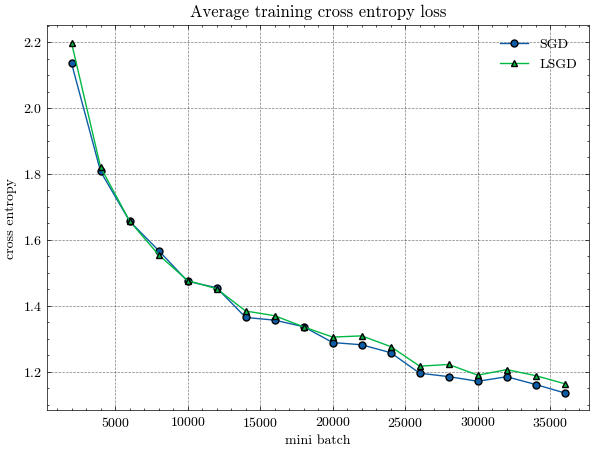

In [8]:
fig = plt.figure(figsize=(7, 5))

plt.plot(
    2000 * (1 + np.arange(len(sgd_losses))),
    sgd_losses,
    label="SGD",
    marker="o",
    mec="k",
    ms=5,
)
plt.plot(
    2000 * (1 + np.arange(len(lsgd_losses))),
    lsgd_losses,
    label="LSGD",
    marker="^",
    mec="k",
    ms=5,
)
plt.legend()

plt.xlabel("mini batch")
plt.ylabel("cross entropy")
plt.title("Average training cross entropy loss")
plt.show()
plt.close()